In [3]:
# !wget https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

Connecting to raw.githubusercontent.com (151.101.108.133:443)
saving to 'tokenization.py'
'tokenization.py' saved


In [1]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

In [2]:
import pathlib

In [3]:
data_p = pathlib.Path('D:/kaggle/data/nlp_tweet')

In [4]:
df_train = pd.read_csv(data_p/'train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv(data_p/'test.csv', dtype={'id': np.int16})

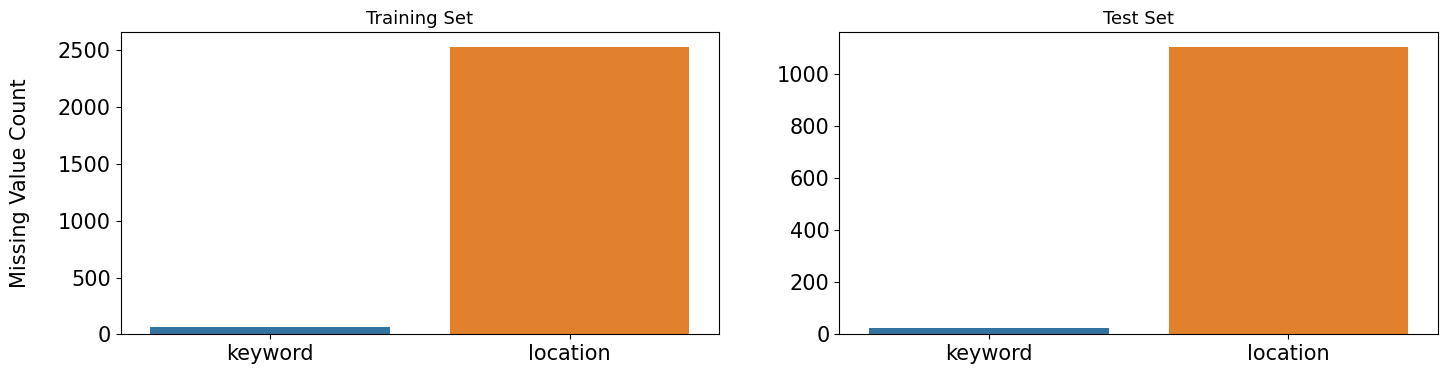

In [5]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [6]:
df_leak_raw = pd.read_csv(data_p/'socialmedia-disaster-tweets-DFE.csv', encoding='ISO-8859-1')
df_leak_raw

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,778261105,True,golden,100,NaN,Relevant,0.7629,Relevant,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,5675678.0,NaN
10872,778261106,True,golden,90,NaN,Relevant,0.9203,Relevant,NaN,NaN,Police investigating after an e-bike collided ...,4234.0,NaN
10873,778261107,True,golden,102,NaN,Relevant,1.0000,Relevant,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,3242.0,NaN
10874,778261108,True,golden,96,NaN,Relevant,0.8419,Relevant,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,457.0,NaN


In [7]:
df_test.shape

(3263, 4)

In [8]:
df_leak = df_leak_raw[['choose_one', 'text']]
df_leak['target'] = (df_leak['choose_one'] == 'Relevant').astype(np.int8)
df_leak['id'] = df_leak.index.astype(np.int16)
df_leak.drop(columns=['choose_one', 'text'], inplace=True)
df_leak.shape

C:\Users\SSG\scoop\apps\anaconda3\current\envs\kg37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\SSG\scoop\apps\anaconda3\current\envs\kg37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\SSG\scoop\apps\anaconda3\current\envs\kg37\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set

(10876, 2)

In [9]:
df_test

,id,keyword,location,text
0,0,no_keyword,no_location,Just happened a terrible car crash
1,2,no_keyword,no_location,"Heard about #earthquake is different cities, s..."
2,3,no_keyword,no_location,"there is a forest fire at spot pond, geese are..."
3,9,no_keyword,no_location,Apocalypse lighting. #Spokane #wildfires
4,11,no_keyword,no_location,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,no_keyword,no_location,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,no_keyword,no_location,Storm in RI worse than last hurricane. My city...
3260,10868,no_keyword,no_location,Green Line derailment in Chicago http://t.co/U...
3261,10874,no_keyword,no_location,MEG issues Hazardous Weather Outlook (HWO) htt...


In [12]:
# Creating target and id
df_leak['target'] = (df_leak['choose_one'] == 'Relevant').astype(np.int8)
df_leak['id'] = df_leak.index.astype(np.int16)
df_leak.drop(columns=['choose_one', 'text'], inplace=True)

# Merging target to test set
df_test = df_test.merge(df_leak, on=['id'], how='left')

print('Leaked Data Set Shape = {}'.format(df_leak.shape))
print('Leaked Data Set Memory Usage = {:.2f} MB'.format(df_leak.memory_usage().sum() / 1024**2))

perfect_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
perfect_submission['target'] = df_test['target'].values
perfect_submission.to_csv('perfect_submission.csv', index=False)
perfect_submission.describe()

Leaked Data Set Shape = (10876, 13)
Leaked Data Set Memory Usage = 0.93 MB


FileNotFoundError: [Errno 2] File /kaggle/input/nlp-getting-started/sample_submission.csv does not exist: '/kaggle/input/nlp-getting-started/sample_submission.csv'